In [17]:
import numpy as np
from skimage.io import imread
from skimage.filter import threshold_otsu
import matplotlib.pyplot as plt
from lasagne import easy
from skimage.transform import resize
from lasagne.datasets.mnist import MNIST
%matplotlib inline

In [18]:
texture = imread("1.1.07.tiff") / 255.
texture = texture.astype(np.float32)

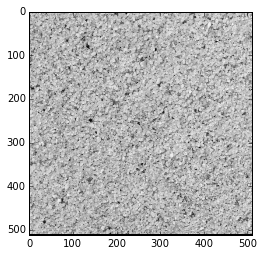

In [3]:
plt.imshow(texture, cmap="gray")

In [19]:
data = MNIST()
data.load()

In [5]:
w, h = 28, 28

In [20]:
texture = resize(texture, (w, h)).astype(np.float32)
X = data.X.reshape((data.X.shape[0], 28, 28))
X = X[0:1000]

X_b = np.zeros((X.shape[0], w, h))
for i in range(X_b.shape[0]):
    X_b[i] = resize(X[i], (w, h))
X = X_b
X = X <= threshold_otsu(X)
X = X.astype(np.float32)
X = 1 - X

In [21]:
digit = X[20]
digit = resize(digit, texture.shape)

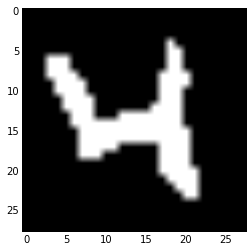

In [8]:
plt.imshow(digit, cmap="gray")

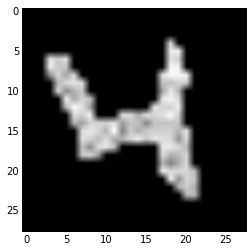

In [9]:
plt.imshow(digit*texture, cmap="gray")

In [22]:
from lasagne.generative.capsule import Capsule
from lasagne.easy import BatchIterator

In [23]:
class BlendingBatchIterator(BatchIterator):
    
     def transform(self, batch_index, V):
        assert self.batch_size is not None 
        assert self.nb_batches is not None 

        if isinstance(batch_index, T.TensorVariable):
            batch_slice = get_batch_slice(batch_index,
                                          self.batch_size)
        else:
            batch_slice = slice(batch_index * self.batch_size,
                                (batch_index+1) * self.batch_size)

        d = OrderedDict()
        d["X"] = V["X"][batch_slice]
        d["x2"] = texture[np.newaxis, :, :].repeat(batch_slice.stop-batch_slice.start, 
                                                   axis=0).astype(np.float32)
        d["o"] = d["X"] * d["x2"]
        return d        

In [24]:
from lasagne.easy import BatchOptimizer, LightweightModel
from collections import OrderedDict
from lasagne import init, layers, updates, nonlinearities
from lasagne.layers.helper import get_all_layers
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano

def corrupted_masking_noise(rng, x, corruption_level):
    return rng.binomial(size=x.shape, n=1, p=1 - corruption_level) * x

def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)



In [25]:
#Modèle "digit"
x_in = layers.InputLayer((None, w, h))
hid = x_in
hid = layers.DenseLayer(hid, num_units=500, nonlinearity=nonlinearities.sigmoid)
o = layers.DenseLayer(hid, num_units=w*h, nonlinearity=nonlinearities.sigmoid)
o = layers.ReshapeLayer(o, ([0], w, h))
model = LightweightModel([x_in], [o])

all_layers = get_all_layers(o)
digit_all_layers = all_layers                    

rng = rng_mrg.MRG_RandomStreams()

def loss_function(model, tensors):
    X = tensors["X"]
    #X_noisy = X * (rng.uniform(X.shape) < 0.6)
    X_noisy = corrupted_salt_and_pepper(rng, X, 0.4)
    x_hat, = model.get_output(X_noisy)
    #l1 = 0.01 * sum( T.abs_(layer.W).sum() for layer in all_layers[1:-1])    
    l1 = 0
    diversity=0
    #diversity = -0.1*(
    #    T.var((all_layers[1].W**2).sum(axis=1))+
    #    T.var((all_layers[2].W**2).sum(axis=1))+
    #    T.var((all_layers[3].W**2).sum(axis=1))
    #)
    return -(X * T.log(x_hat) + 
             (1 - X) * T.log(1 - x_hat)).sum(axis=(1, 2)).mean() + diversity + l1

input_variables = dict(
    X=dict(tensor_type=T.tensor3),
)

def get_reconstruction_error(model, X):
    x_hat, = model.get_output(X)
    return -(X * T.log(x_hat) + 
            (1 - X) * T.log(1 - x_hat)).sum(axis=(1, 2)).mean()


functions = dict(
    predict=dict(
        get_output=lambda model, X:model.get_output(X)[0],
        params=["X"]
    ),
    get_reconstruction_error=dict(
        get_output=get_reconstruction_error,
        params=["X"]
    )
)

for i, layer in enumerate(all_layers[1:-1]):
    functions["get_layer_{0}".format(i + 1)] = dict(get_output=lambda model, X: model.get_output(X)[0],
                                                    params=["X"])

class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        status["reconstruction_error"] = capsule.get_reconstruction_error(X)
        
        for i, layer in enumerate(all_layers[1:-1]):
            getter = getattr(capsule, "get_layer_{0}".format(i + 1))
            activations = getter(X)
            status["activations_{0}_mean".format(i  +1)] = activations.mean()
            status["activations_{0}_std".format(i  +1)] = activations.std()
            
        return status
    
batch_optimizer = MyBatchOptimizer(verbose=1,
                                   max_nb_epochs=100,
                                   batch_size=10,
                                   optimization_procedure=(updates.adagrad, 
                                                           {"learning_rate": 0.001}))
capsule = Capsule(
    input_variables, model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)


capsule.fit(X=X)

KeyboardInterrupt: 

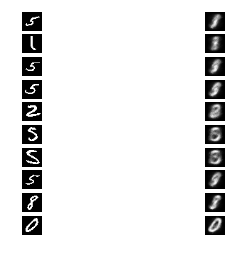

In [14]:
x_hat = capsule.predict(X)
k = 1
for i in range(10):
    d = np.random.randint(0, X.shape[0])
    plt.axis('off')
    plt.subplot(10, 2, k)
    plt.imshow(X[d], cmap="gray")
    plt.axis('off')
    plt.subplot(10, 2, k + 1)
    plt.imshow(x_hat[d], cmap="gray")
    plt.axis('off')
    k += 2

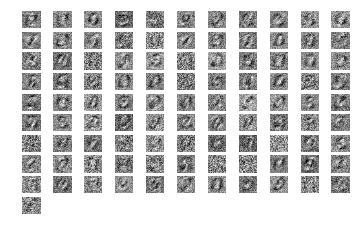

In [15]:
from lasagne.misc.plot_weights import grid_plot
F = all_layers[1].W.get_value().reshape( (w, h, -1) )
F = F.transpose(2, 0, 1)
grid_plot(F[0:100], imshow_options=dict(cmap="gray"))
plt.show()

KeyError: 'activations_3_mean'

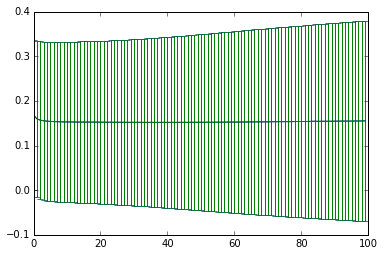

In [16]:
from lasagne.easy import get_stat
for i in range(1, 4):
    m = get_stat("activations_{0}_mean".format(i),batch_optimizer.stats)
    s = get_stat("activations_{0}_std".format(i), batch_optimizer.stats)
    e = get_stat("epoch",batch_optimizer.stats)
    plt.errorbar(x=e, y=m, yerr=s, label="layer{0}".format(i))
plt.legend(loc='best')
plt.show()

In [27]:
#modèle fusion

# Partie parallele

#X1
x1_in = layers.InputLayer((None, w, h))

hid = layers.DenseLayer(x1_in, 
                        num_units=500, 
                        nonlinearity=nonlinearities.sigmoid)
hid1 = hid
#X2
x2_in = layers.InputLayer((None, w, h))
hid = layers.DenseLayer(x2_in, num_units=500, 
                        nonlinearity=nonlinearities.sigmoid)
hid2 = hid
# Partie combinaison
hid = layers.ConcatLayer([hid1, hid2], axis=1)

o = layers.DenseLayer(hid, num_units=w*h, nonlinearity=nonlinearities.tanh)
o = layers.ReshapeLayer(o, ([0], w, h))
model = LightweightModel([x1_in, x2_in], [o])

In [28]:
def loss_function(model, tensors):
    o_hat, = model.get_output(tensors["X"], tensors["x2"])
    return ((o_hat - tensors["o"])**2).sum(axis=(1, 2)).mean()

input_variables = dict(
    X=dict(tensor_type=T.tensor3),
    x2=dict(tensor_type=T.tensor3),
    o=dict(tensor_type=T.tensor3)
)

functions = dict(
    blend=dict(
        get_output=lambda model, X, X2:model.get_output(X, X2)[0],
        params=["X", "x2"]
    )
)

batch_optimizer = BatchOptimizer(verbose=1,
                                 max_nb_epochs=500,
                                 optimization_procedure=(updates.adagrad, {"learning_rate": 0.001}))
capsule = Capsule(
    input_variables, model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
    batch_iterator=BlendingBatchIterator()
)

In [29]:
capsule.fit(X=X, x2=None, o=None)

  epoch    loss_std    loss_train
-------  ----------  ------------
      0     49.8456       52.5451
  epoch    loss_std    loss_train
-------  ----------  ------------
      1    0.531064        27.309
  epoch    loss_std    loss_train
-------  ----------  ------------
      2    0.503811       26.3812
  epoch    loss_std    loss_train
-------  ----------  ------------
      3    0.488037       25.6656
  epoch    loss_std    loss_train
-------  ----------  ------------
      4    0.475962       25.0699
  epoch    loss_std    loss_train
-------  ----------  ------------
      5    0.465784       24.5491
  epoch    loss_std    loss_train
-------  ----------  ------------
      6    0.456649       24.0803
  epoch    loss_std    loss_train
-------  ----------  ------------
      7    0.448284       23.6509
  epoch    loss_std    loss_train
-------  ----------  ------------
      8    0.440553       23.2525
  epoch    loss_std    loss_train
-------  ----------  ------------
      9    0.4

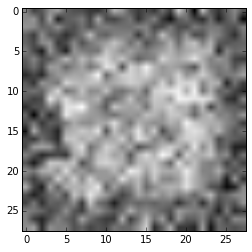

In [33]:
i=50
plt.imshow(X[i], cmap="gray")
plt.imshow(capsule.blend(X[i:i+1], texture[np.newaxis, :, :])[0], cmap="gray")